In [2]:
import numpy as np
import matplotlib.pyplot  as plt

from qiskit import(
    QuantumCircuit, 
    ClassicalRegister, 
    QuantumRegister,
    transpile)
from qiskit.providers.basic_provider import BasicProvider

 
backend = BasicProvider().get_backend('basic_simulator')


from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2, TwoLocal

In [3]:
N_s = 8
J = 0.2
h = 1
g = 0.3
XX_terms = []
Z_terms = []
ZZ_terms = []
for i in range(N_s):
    term = list("I" * N_s)
    term[i] = "X"
    term[(i + 1) % N_s] = "X"
    XX_terms.append(("".join(term), -J))

    term = list("I" * N_s)
    term[i] = "Z"
    Z_terms.append(("".join(term), -h))

    term = list("I" * N_s)
    term[i] = "Z"
    term[(i + 1) % N_s] = "Z"
    ZZ_terms.append(("".join(term), -g))

Ham_terms = XX_terms + Z_terms + ZZ_terms

Ham_op = SparsePauliOp.from_list(Ham_terms)

In [4]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=Ham_op)
ref_value = result._eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -10.46159


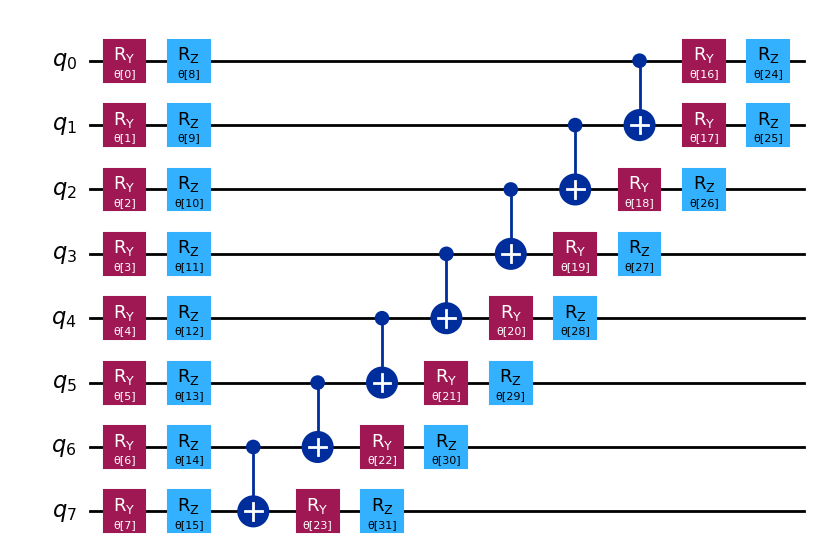

In [5]:
# define ansatz and optimizer
from qiskit.circuit.library import n_local
from qiskit_algorithms.optimizers import SPSA, SLSQP
iterations = 8000
ansatzs = []
for i in range(1):
    ansatz = efficient_su2(N_s, reps=1, insert_barriers=False)
    ansatzs.append(ansatz)
spsa = SPSA(maxiter=iterations)
# slsqp = SLSQP(maxiter=iterations)
ansatzs[0].draw("mpl", style="iqp")

In [6]:
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

seed = 150
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(options={"default_precision": 1e-5})

In [7]:
# instantiate and run VQE
from qiskit_algorithms import VQE
for i in range(len(ansatzs)):
    # print("Layers: ", 3)
    vqe = VQE(noiseless_estimator, ansatzs[i], optimizer=spsa, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=Ham_op)

    print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
    print(f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}")

VQE on Aer qasm simulator (no noise): -10.44821
Delta from reference energy value is 0.01338


In [8]:
thetas = []
for key in result.optimal_parameters:
    thetas.append(result.optimal_parameters[key])
thetas

[-6.2071079981968085,
 6.358180309663347,
 3.2165370023779065,
 -0.07426292460054361,
 0.0721593671325987,
 0.07152710891519011,
 3.7501907351716075,
 -4.801040995029839,
 -4.294058620742308,
 0.22738239984250685,
 1.408022124137442,
 -0.8016147789211057,
 0.6098667610415442,
 1.7445304691793013,
 -3.150686608189159,
 3.0981291154657598,
 0.0032439552530774333,
 -0.001193778739830972,
 9.425867312333178,
 3.1410681148136774,
 0.0002961706076449555,
 -0.0073686167755740144,
 2.5338997462978825,
 -4.639266286302129,
 -2.3724653339999406,
 6.681017145453249,
 -3.9040459950263067,
 -3.9564774739743784,
 -7.606930643703703,
 1.0101848664101722,
 0.4915885764797053,
 4.967426244029165]

In [9]:
file = 'vqe-thetas-N' + str(N_s)
file += '-J' + str(J)
file += '-h' + str(h)
file += '-g' + str(g)
file += '.npy'

np.save(file, np.array(thetas))

In [10]:
file

'vqe-thetas-N8-J0.2-h1-g0.3.npy'

Text(0.5, 1.0, 'Convergence with no noise')

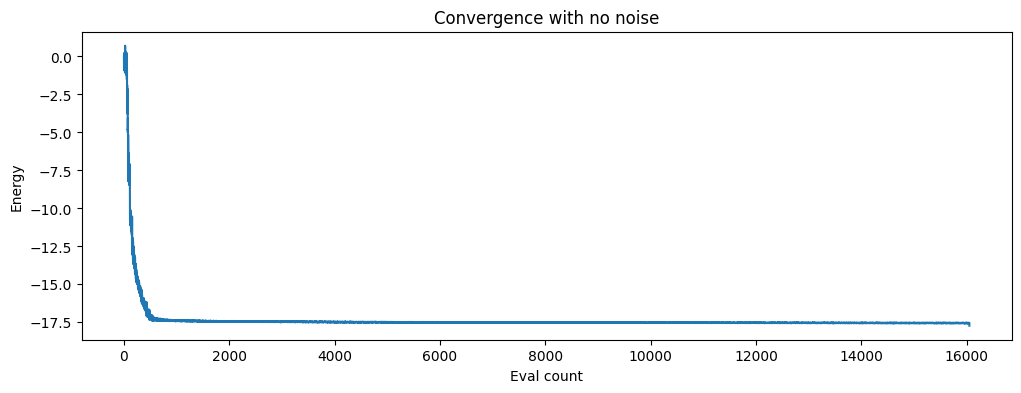

In [110]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")